In [35]:
import split_op as split
import numpy as np
from scipy.special import roots_legendre, lpmv
from tqdm import tqdm

from potential import load_potential
import os

data_path = "data/"
if not os.path.exists(data_path):
    os.makedirs(data_path)

KELVIN = 3.1668105e-6
U = 1822.88839
CM_INV = 4.55633e-6

def centrifugal(r_points, j_tot: int, omega: int, mass_u: float):
    return (j_tot * (j_tot + 1) - 2 * omega * omega) / (2 * mass_u * U * np.power(r_points, 2)) 

class Potential:
    def __init__(self, r_o, r_c, r_s, d6_o, d6_c, d6_s, re_o, re_c, re_s, sigma):
        self.r_o = r_o
        self.r_c = r_c
        self.r_s = r_s
        self.d6_o = d6_o
        self.d6_c = d6_c
        self.d6_s = d6_s
        self.re_o = re_o
        self.re_c = re_c
        self.re_s = re_s
        self.sigma = sigma
    
    @staticmethod
    def default():
        return Potential(3.1787, 0.9908, -1.957, 
                         50 * CM_INV, 50 * CM_INV, 50 * CM_INV, 
                         1, 1, 1, 
                         0)

    def value(self, r, theta):
        r_o = np.sqrt(r ** 2 + self.r_o ** 2 - 2 * r * self.r_o * np.cos(theta))
        r_c = np.sqrt(r ** 2 + self.r_c ** 2 - 2 * r * self.r_c * np.cos(theta))
        r_s = np.sqrt(r ** 2 + self.r_s ** 2 - 2 * r * self.r_s * np.cos(theta))

        pot_o = - self.d6_o * (self.re_o / r_o) ** 6 * (1 - 2 * (self.re_o / r_o) ** 6)
        pot_c = - self.d6_c * (self.re_c / r_c) ** 6 * (1 - 2 * (self.re_c / r_c) ** 6)
        pot_s = - self.d6_s * (self.re_s / r_s) ** 6 * (1 - 2 * (self.re_s / r_s) ** 6)

        pot_sigma = self.sigma * np.cos(theta) ** 2 / (r ** 6)

        return pot_o + pot_c + pot_s + pot_sigma


C:\Users\marcr\AppData\Local\Temp\ipykernel_20112\1792959999.py:49: RuntimeWarning: invalid value encountered in divide
  pot_sigma = self.sigma * np.cos(theta) ** 2 / (r ** 6)


[Text(0, 1.0, ''),
 Text(0, 2.0, ''),
 Text(0, 3.0, ''),
 Text(0, 4.0, ''),
 Text(0, 5.0, ''),
 Text(0, 6.0, '')]

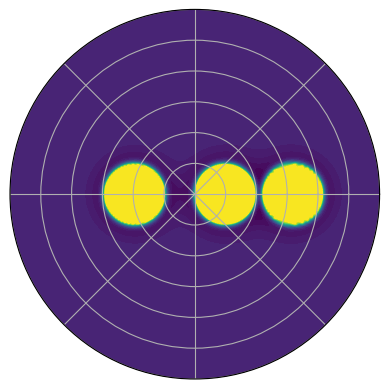

In [36]:
import matplotlib.pyplot as plt

r = np.linspace(0, 6, 300)
theta = np.linspace(0, np.pi, 100)

r_mesh, theta_mesh = np.meshgrid(r, theta, indexing="ij")
potential = Potential.default().value(r_mesh, theta_mesh) / CM_INV

potential = np.clip(potential, -1000, 100)

theta = np.concatenate(([0], theta))
potential = np.concatenate((potential[:, 0:1], potential), axis=1)

theta = np.concatenate((theta, np.flip(-theta)))
potential = np.concatenate((potential, np.flip(potential, axis=1)), axis=1)

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, potential, levels=50)
ax.set_xticklabels([])
ax.set_yticklabels([])

In [23]:
from typing import Callable

def prepare(j_init: int, 
    omega_init: int, 
    j_tot: int, 
    time_step: float = 400, 
    steps_no: float = 300, 
    r_start: float = 50 / 1024, 
    r_end: float = 50, 
    r_no: int = 1024, 
    polar_no: int = 160, 
    mass_u: float = 15.1052848671,
    energy_kelvin: float = 3700, 
    rot_const = 9.243165268327e-7,
    wave_r0: float = 30,
    wave_r_sigma: float = 0.6,
    animation: bool = False,
    frames: int = 60,
    wave_prefix: str = "standard",
    potential: Potential = Potential.default(),
    potential_path = "potentials/",
    transform_xpi: Callable[[float, float], float] = None,
    transform_bsigma: Callable[[float, float], float] = None,
    transform_api: Callable[[float, float], float] = None,
) -> split.Propagation:
    """
    Prepares the split operator propagation of the Ne OCS problem.

    :j_init: initial angular momentum of the OCS molecule
    :omega_init: initial body fixed projection of the OCS angular momentum equal to projection of the total angular momentum
    :j_tot: total angular momentum of the system
    :time_step: time step in the Hartree units of the propagation step
    :steps_no: number of steps in the propagation
    :r_start: starting value of the radial grid
    :r_end: ending value of the radial grid
    :r_no: number of points of the radial grid
    :polar_no: number of points of the angular grid
    :mass_u: reduced mass of the Ne OCS in u units
    :energy_kelvin: energy of the collision in Kelvin units
    :rot_const: rotational constant of the OCS molecule in Hartree units
    :wave_r0: initial radial position of the wave funciton
    :wave_r_sigma: initial radial width of the wave funciton
    :animation: whether to save animations of the wave function
    :frames: number of frames of the animation
    :wave_prefix: prefix of the wave animation filename to be saved
    :wave_legendre_prefix: prefix of the wave animation in the legendre basis filename to be saved
    """

    assert j_tot >= omega_init
    assert j_init >= omega_init

    ############################ grids, wave function creation ################################
    
    time_grid = split.TimeGrid(time_step, steps_no)
    r_grid = split.Grid.linear_continuos("r", r_start, r_end, r_no, 0)
    
    polar_points, weights = roots_legendre(polar_no)
    polar_points = np.flip(np.arccos(polar_points))
    weights = np.flip(weights)
    
    polar_grid = split.Grid.custom("theta", polar_points, weights, 1)

    r_points = np.array(r_grid.points())
    momentum = np.sqrt(2 * mass_u * U * energy_kelvin * KELVIN)

    wave_r_init = np.array([split.gaussian_distribution(r_points[i], wave_r0, wave_r_sigma, momentum) for i in range(r_no)])
    wave_polar_init = lpmv(omega_init, j_init, np.cos(polar_points))

    wave_init = np.outer(wave_r_init, wave_polar_init)
    wave_function = split.WaveFunction(wave_init.flatten(), [r_grid, polar_grid])

    ############################ operation creation ################################

    r_mesh, polar_mesh = np.meshgrid(r_points, polar_points, indexing="ij")

    potential = load_potential(potential_path, "potential.dat", r_grid, polar_grid, 5, 5, False)

    centrifugal_potential = centrifugal(r_points, j_tot, omega_init, mass_u)
    centrifugal_potential = np.broadcast_to(np.expand_dims(centrifugal_potential, 1), (r_no, polar_no))

    bsigma_gamma = load_potential(potential_path, "BSigma_gamma.dat", r_grid, polar_grid, 5, 5, True)
    if transform_bsigma is not None:
        bsigma_gamma = np.multiply(bsigma_gamma, transform_bsigma(r_mesh, polar_mesh))

    api_gamma = load_potential(potential_path, "APi_gamma.dat", r_grid, polar_grid, 5, 5, True)
    if transform_api is not None:
        api_gamma = np.multiply(api_gamma, transform_api(r_mesh, polar_mesh))

    potential = potential + centrifugal_potential + complex(0, -0.5) * (bsigma_gamma + api_gamma)
    potential_with_bsigma_prop = split.complex_n_dim_into_propagator(potential.shape, potential.flatten(), time_grid)

    loss_checker = split.LossChecker.new_with_saver("bsigma", frames, f"{wave_prefix}_bsigma", time_grid) if animation else split.LossChecker("bsigma")
    potential_with_bsigma_prop.set_loss_checked(loss_checker)

    xpi_gamma = load_potential(potential_path, "XPi_gamma.dat", r_grid, polar_grid, 5, 3, True)
    if transform_xpi is not None:
        xpi_gamma = np.multiply(xpi_gamma, transform_xpi(r_mesh, polar_mesh))

    xpi_gamma = complex(0, -0.5) * xpi_gamma
    xpi_gamma_prop = split.complex_n_dim_into_propagator(xpi_gamma.shape, xpi_gamma.flatten(), time_grid)
    
    loss_checker = split.LossChecker.new_with_saver("xpi", frames, f"{wave_prefix}_xpi", time_grid) if animation else split.LossChecker("xpi")
    xpi_gamma_prop.set_loss_checked(loss_checker)

    leak_control = split.LeakControl(split.LossChecker("leak control"))
    dumping_border = split.BorderDumping(5., 1., r_grid)

    angular_transformation = None
    angular_prop = None

    if omega_init == 0:
        angular_transformation = split.legendre_transformation(polar_grid)

        shape, angular_kinetic_op = split.rotational_hamiltonian(r_grid, polar_grid, mass_u, rot_const)
        angular_prop = split.n_dim_into_propagator(shape, angular_kinetic_op, time_grid)
    else:
        l_grid = split.Grid.linear_countable("angular_momentum",
                                             np.abs(omega_init),
                                             polar_no - 1 + np.abs(omega_init),
                                             polar_no,
                                             1)
        transformation_matrix = np.zeros((polar_no, polar_no), dtype=complex)
        l_points = np.array(l_grid.points())

        assert omega_init >= 0
        for i in range(polar_no):
            normalization = 1
            for k in range(-np.abs(omega_init), np.abs(omega_init)):
                normalization *= l_points[i] + 1 + k

            transformation_matrix[i, :] = np.sqrt(weights * (l_points[i] + 0.5) / normalization) \
                * lpmv(omega_init, l_points[i], np.cos(polar_points))
            
        q, r = np.linalg.qr(transformation_matrix.transpose())
        transformation_matrix = q.transpose()
        
        angular_transformation = split.MatrixTransformation(polar_grid, l_grid)
        angular_transformation.set_matrix(transformation_matrix.flatten(), transformation_matrix.transpose().flatten())

        rot_hamiltonian = (1 / (2 * mass_u * U * r_mesh ** 2) + rot_const) * l_points * (l_points + 1)

        angular_prop = split.n_dim_into_propagator(rot_hamiltonian.shape, rot_hamiltonian.flatten(), time_grid)

    fft_transformation = split.FFTTransformation(r_grid, "r momentum")

    kinetic_op = split.kinetic_hamiltonian(r_grid, mass_u, energy_kelvin)
    kinetic_prop = split.one_dim_into_propagator(kinetic_op, r_grid, time_grid, step = "full")

    ################################ populating operation stack ####################################

    operation_stack = split.OperationStack()
    potential_with_bsigma_prop.add_operation(operation_stack)
    xpi_gamma_prop.add_operation(operation_stack)

    if animation:
        wave_saver = split.WaveFunctionSaver(data_path, f"{wave_prefix}_wave_animation", time_grid, r_grid, polar_grid, frames)
        wave_saver.add_operation(operation_stack)

        polar_saver = split.StateSaver(data_path, f"{wave_prefix}_polar_animation", time_grid, polar_grid, frames)
        polar_saver.add_operation(operation_stack)

    dumping_border.add_operation(operation_stack)
    leak_control.add_operation(operation_stack)

    angular_transformation.add_operation(operation_stack, True)

    if animation:
        angular_grid = angular_transformation.transformed_grid()
        wave_legendre_saver = split.StateSaver(data_path, f"{wave_prefix}_angular_animation", time_grid, angular_grid, frames)
        wave_legendre_saver.add_operation(operation_stack)

    angular_prop.add_operation(operation_stack)

    fft_transformation.add_operation(operation_stack, True)
    kinetic_prop.add_operation(operation_stack)

    ################################ propagation creation ####################################

    propagation = split.Propagation()
    propagation.set_wave_function(wave_function)
    propagation.set_time_grid(time_grid)
    propagation.set_operation_stack(operation_stack)

    return propagation

def default_value(name: str):
    import inspect

    return inspect.signature(prepare).parameters.get(name).default

class CumulativeLosses:
    def __init__(self, j_init: int, energy_kelvin: float = default_value("energy_kelvin")) -> None:
        self.bsigma_losses = []
        self.xpi_losses = []

        self.j_totals = [j_init + np.ceil(i * 5.5 * np.sqrt(energy_kelvin / 2000)) for i in range(50)]
    
    def extract_loss(self, propagation: split.Propagation) -> None:
        losses = propagation.get_losses()

        self.bsigma_losses.append(losses[0])
        self.xpi_losses.append(losses[1])

    def save_losses(self, filename: str) -> None:
        combined = np.vstack((self.j_totals, self.bsigma_losses, self.xpi_losses)).transpose()
        np.savetxt(f"{data_path}{filename}.dat", combined, delimiter=" ", header="j_total\tbsigma_loss\txpi_loss")

# Animations

In [22]:
print("j init: 0, omega init: 0, j_tot: 150")
propagation = prepare(0, 0, 150, animation=True, steps_no=600, wave_prefix="standard_0_0")

propagation.propagate()
print(propagation.get_losses())
propagation.save_savers()

print("j init: 1, omega init: 0, j_tot: 150")
propagation = prepare(1, 0, 150, animation=True, steps_no=600, wave_prefix="standard_1_0")

propagation.propagate()
print(propagation.get_losses())
propagation.save_savers()

print("j init: 1, omega init: 1, j_tot: 150")
propagation = prepare(1, 1, 150, animation=True, steps_no=600, wave_prefix="standard_1_1")

propagation.propagate()
print(propagation.get_losses())
propagation.save_savers()

j init: 0, omega init: 0, j_tot: 150
[0.46472876677996305, 0.19602354128947844]
j init: 0, omega init: 0, j_tot: 150
[0.5148534748059506, 0.1745601061339994]
j init: 0, omega init: 0, j_tot: 150
[0.43546324647904394, 0.20644062446518938]


In [7]:
print("j init: 0, omega init: 0, j_tot: 150")
propagation = prepare(0, 0, 150, animation=True, rot_const=9.243165268327e-9, wave_prefix="small_rot_scaling")

propagation.propagate()
print(propagation.get_losses())
propagation.save_savers()

j init: 0, omega init: 0, j_tot: 150
[0.4944627249100613, 0.202304427186737]


In [8]:
print("j init: 0, omega init: 0, j_tot: 150")
propagation = prepare(0, 0, 150, animation=True, rot_const=9.243165268327e-5, wave_prefix="big_rot_scaling")

propagation.propagate()
print(propagation.get_losses())
propagation.save_savers()

j init: 0, omega init: 0, j_tot: 150
[0.4704726787828905, 0.18577229490843578]


# Single losses

In [12]:
print("j init: 0, omega init: 0, j_tot: 150")
propagation = prepare(0, 0, 150)
propagation.propagate()
print(propagation.get_losses())

print("j init: 1, omega init: 0, j_tot: 150")
propagation = prepare(1, 0, 150)
propagation.propagate()
print(propagation.get_losses())

print("j init: 1, omega init: 1, j_tot: 150")
propagation = prepare(1, 1, 150)
propagation.propagate()
print(propagation.get_losses())

j init: 0, omega init: 0, j_tot: 150
[0.4647287664033311, 0.1960235411862791]
j init: 1, omega init: 0, j_tot: 150
[0.514853474601179, 0.17456010605305988]
j init: 1, omega init: 1, j_tot: 150
[0.43968510740923605, 0.20676032235104247]


# Single cross sections

In [10]:
j_init = 0
omega_init = 0
energy_kelvin = 3700
losses = CumulativeLosses(j_init, energy_kelvin)

for j_tot in tqdm(losses.j_totals):
    propagation = prepare(j_init, omega_init, j_tot, energy_kelvin=energy_kelvin)
    propagation.propagate()
    losses.extract_loss(propagation)
losses.save_losses(f"losses_{energy_kelvin}_{j_init}_{omega_init}")

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:27<00:00,  5.35s/it]


In [11]:
j_init = 1
omega_init = 0
energy_kelvin = 3700
losses = CumulativeLosses(j_init, energy_kelvin)

for j_tot in tqdm(losses.j_totals):
    propagation = prepare(j_init, omega_init, j_tot, energy_kelvin=energy_kelvin)
    propagation.propagate()
    losses.extract_loss(propagation)
losses.save_losses(f"losses_{energy_kelvin}_{j_init}_{omega_init}")

100%|██████████| 50/50 [04:25<00:00,  5.30s/it]


In [12]:
j_init = 1
omega_init = 1
energy_kelvin = 3700
losses = CumulativeLosses(j_init, energy_kelvin)

for j_tot in tqdm(losses.j_totals):
    propagation = prepare(j_init, omega_init, j_tot, energy_kelvin=energy_kelvin)
    propagation.propagate()
    losses.extract_loss(propagation)
losses.save_losses(f"losses_{energy_kelvin}_{j_init}_{omega_init}")

100%|██████████| 50/50 [03:46<00:00,  4.53s/it]


# Cross sections - energy dependence 

In [34]:
energies = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

In [35]:
for energy_kelvin in energies:
    print("energy", energy_kelvin)
    j_init = 0
    omega_init = 0
    time_step = default_value("time_step")*np.sqrt(energy_kelvin/default_value("energy_kelvin"))
    losses = CumulativeLosses(j_init, energy_kelvin)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, energy_kelvin=energy_kelvin, time_step=time_step)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"losses_{energy_kelvin}_{j_init}_{omega_init}")

energy 100


100%|██████████| 50/50 [01:28<00:00,  1.76s/it]


energy 500


100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


energy 1000


100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


energy 1500


100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


energy 2000


100%|██████████| 50/50 [01:28<00:00,  1.76s/it]


energy 2500


100%|██████████| 50/50 [01:27<00:00,  1.76s/it]


energy 3000


100%|██████████| 50/50 [01:27<00:00,  1.76s/it]


energy 3500


100%|██████████| 50/50 [01:28<00:00,  1.76s/it]


energy 4000


100%|██████████| 50/50 [01:28<00:00,  1.76s/it]


energy 4500


100%|██████████| 50/50 [01:28<00:00,  1.76s/it]


energy 5000


100%|██████████| 50/50 [01:27<00:00,  1.74s/it]


In [36]:
for energy_kelvin in energies:
    print("energy", energy_kelvin)
    j_init = 1
    omega_init = 0
    time_step = default_value("time_step")*np.sqrt(energy_kelvin/default_value("energy_kelvin"))
    losses = CumulativeLosses(j_init, energy_kelvin)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, energy_kelvin=energy_kelvin, time_step=time_step)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"losses_{energy_kelvin}_{j_init}_{omega_init}")

energy 100


100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


energy 500


100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


energy 1000


100%|██████████| 50/50 [01:27<00:00,  1.75s/it]


energy 1500


100%|██████████| 50/50 [01:28<00:00,  1.76s/it]


energy 2000


100%|██████████| 50/50 [01:26<00:00,  1.74s/it]


energy 2500


100%|██████████| 50/50 [01:25<00:00,  1.72s/it]


energy 3000


100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


energy 3500


100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


energy 4000


100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


energy 4500


100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


energy 5000


100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


In [37]:
for energy_kelvin in energies:
    print("energy", energy_kelvin)
    j_init = 1
    omega_init = 1
    time_step = default_value("time_step")*np.sqrt(energy_kelvin/default_value("energy_kelvin"))
    losses = CumulativeLosses(j_init, energy_kelvin)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, energy_kelvin=energy_kelvin, time_step=time_step)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"losses_{energy_kelvin}_{j_init}_{omega_init}")

energy 100


100%|██████████| 50/50 [01:27<00:00,  1.76s/it]


energy 500


100%|██████████| 50/50 [01:27<00:00,  1.75s/it]


energy 1000


100%|██████████| 50/50 [01:28<00:00,  1.76s/it]


energy 1500


100%|██████████| 50/50 [01:27<00:00,  1.74s/it]


energy 2000


100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


energy 2500


100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


energy 3000


100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


energy 3500


100%|██████████| 50/50 [01:26<00:00,  1.74s/it]


energy 4000


100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


energy 4500


100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


energy 5000


100%|██████████| 50/50 [01:27<00:00,  1.75s/it]


# Convergences 

## Time step

In [14]:
time_steps = [50, 100, 200, 400, 600, 1000, 2000, 4000, 6000]

In [15]:
for time_step in time_steps:
    print("time_step", time_step)
    j_init = 0
    omega_init = 0
    steps_no = max(int(default_value("steps_no") * default_value("time_step") / time_step), 100)
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, time_step=time_step, steps_no=steps_no)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"time_step_{time_step}_{j_init}_{omega_init}")

time_step 50


100%|██████████| 50/50 [10:24<00:00, 12.49s/it]


time_step 100


100%|██████████| 50/50 [05:11<00:00,  6.23s/it]


time_step 200


100%|██████████| 50/50 [02:34<00:00,  3.10s/it]


time_step 400


100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


time_step 600


100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


time_step 1000


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


time_step 2000


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


time_step 4000


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


time_step 6000


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


In [16]:
for time_step in time_steps:
    print("time_step", time_step)
    j_init = 1
    omega_init = 0
    steps_no = max(int(default_value("steps_no") * default_value("time_step") / time_step), 100)
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, time_step=time_step, steps_no=steps_no)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"time_step_{time_step}_{j_init}_{omega_init}")

time_step 50


100%|██████████| 50/50 [10:17<00:00, 12.35s/it]


time_step 100


100%|██████████| 50/50 [05:03<00:00,  6.08s/it]


time_step 200


100%|██████████| 50/50 [02:34<00:00,  3.08s/it]


time_step 400


100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


time_step 600


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


time_step 1000


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


time_step 2000


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


time_step 4000


100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


time_step 6000


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


In [17]:
for time_step in time_steps:
    print("time_step", time_step)
    j_init = 1
    omega_init = 1
    steps_no = max(int(default_value("steps_no") * default_value("time_step") / time_step), 100)
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, time_step=time_step, steps_no=steps_no)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"time_step_{time_step}_{j_init}_{omega_init}")

time_step 50


100%|██████████| 50/50 [10:11<00:00, 12.24s/it]


time_step 100


100%|██████████| 50/50 [05:10<00:00,  6.22s/it]


time_step 200


100%|██████████| 50/50 [02:36<00:00,  3.14s/it]


time_step 400


100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


time_step 600


100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


time_step 1000


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


time_step 2000


100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


time_step 4000


100%|██████████| 50/50 [00:29<00:00,  1.72it/s]


time_step 6000


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


## radial grid

In [ ]:
r_nos = [128, 256, 512, 1024, 2048, 4096]

In [ ]:
for r_no in r_nos:
    print("radial_no", r_no)
    j_init = 0
    omega_init = 0
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, r_no=r_no)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"radial_scaling_{r_no}_{j_init}_{omega_init}")

In [ ]:
for r_no in r_nos:
    print("radial_no", r_no)
    j_init = 1
    omega_init = 0
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, r_no=r_no)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"radial_scaling_{r_no}_{j_init}_{omega_init}")

In [ ]:
for r_no in r_nos:
    print("radial_no", r_no)
    j_init = 1
    omega_init = 1
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, r_no=r_no)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"radial_scaling_{r_no}_{j_init}_{omega_init}")

## polar grid

In [ ]:
polar_nos = [20, 40, 80, 160, 320, 640]

In [ ]:
for polar_no in polar_nos:
    print("polar_no", polar_no)
    j_init = 0
    omega_init = 0
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, polar_no=polar_no)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"polar_scaling_{polar_no}_{j_init}_{omega_init}")

In [ ]:
for polar_no in polar_nos:
    print("polar_no", polar_no)
    j_init = 1
    omega_init = 0
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, polar_no=polar_no)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"polar_scaling_{polar_no}_{j_init}_{omega_init}")

In [ ]:
for polar_no in polar_nos:
    print("polar_no", polar_no)
    j_init = 1
    omega_init = 1
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, polar_no=polar_no)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"polar_scaling_{polar_no}_{j_init}_{omega_init}")

## wave width

In [ ]:
widths = [0.1, 0.3, 0.6, 1, 2, 4]

In [ ]:
for width in widths:
    print("wave width", width)
    j_init = 0
    omega_init = 0
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, wave_r_sigma=width)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"width_scaling_{width}_{j_init}_{omega_init}")

In [ ]:
for width in widths:
    print("wave width", width)
    j_init = 1
    omega_init = 0
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, wave_r_sigma=width)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"width_scaling_{width}_{j_init}_{omega_init}")

In [ ]:
for width in widths:
    print("wave width", width)
    j_init = 1
    omega_init = 1
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, wave_r_sigma=width)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"width_scaling_{width}_{j_init}_{omega_init}")